## Imports

In this notebook, AI was used for:
- graphic visualisation of the network and results
- solve problems in the code due to syntax
- find the necessary library functions

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx 

import folium
import json
import geopandas as gpd
from shapely.geometry import LineString
import json
import heapq
from collections import defaultdict, deque
import queue

import random
import os 

## Data

In [2]:
df_links = pd.read_csv("data/IC_NETWORK/df_links.csv") 
df_distances = pd.read_csv("data/distance_matrix.csv") 
df_od = pd.read_csv("data/od_df.csv") 

In [ ]:
to_remove = ['Lugano Nord']

df_distances = df_distances.drop('Lugano Nord', axis=1)
df_distances = df_distances[~df_distances['Unnamed: 0'].isin(to_remove)]
df_distances = df_distances.reset_index(drop=True)

In [4]:
map = df_distances.columns[1:].to_list()

df_od['org'] = df_od['org'].map(lambda x: map[x])
df_od['dest'] = df_od['dest'].map(lambda x: map[x])

### Data manipulation

To correctly model the network with transfers, we decided to model the transfers between lines at a station as seperate edges. By doing this we can have full control over transfer costs, line headways, ...

Each station - line pair is modeled as a seperate node in the network, to change lines at a node there is an additional edge to represent the transfer. 

### Modelling transfers

In [ ]:
# Function to split multiple train lines and create individual connections
def process_multi_line_connections(df_links):
    
    rows = []
    
    for _, row in df_links.iterrows():
        if ',' in str(row['IC_lines']):
            for line in [l.strip() for l in row['IC_lines'].split(',')]:
                new_row = row.copy()
                new_row['IC_lines'] = line
                rows.append(new_row)
        else:
            rows.append(row)

    df_expanded = pd.DataFrame(rows)
    
    return df_expanded

In [ ]:
# Create bidirectional network with individual train lines
def create_bidirectional_network(df_expanded):
    
    df_reversed = df_expanded.copy()
    df_reversed['start_node'], df_reversed['end_node'] = df_reversed['end_node'], df_reversed['start_node']
    
    df_bidirectional = pd.concat([df_expanded, df_reversed], ignore_index=True)
    
    return df_bidirectional

In [ ]:
# Add transfer edges between lines at the same station
def add_transfer_edges(df_bidirectional, transfer_time):
    
    station_lines = []
    for _, row in df_bidirectional.iterrows():
        station_lines.append((row['start_node'], row['IC_lines']))
    
    station_lines = list(set(station_lines))
    
    stations = {}
    for station, line in station_lines:
        if station not in stations:
            stations[station] = []
        stations[station].append(line)
    
    transfer_edges = []
    
    for station, lines in stations.items():
        if len(lines) > 1:  
            for i, line1 in enumerate(lines):
                for line2 in lines[i+1:]:
                    transfer_edges.append({
                        'start_node': station,
                        'end_node': station,
                        'distance [m]': 0,
                        'IC_lines': f"TRANSFER_{line1}_to_{line2}",
                        'transfer_time': transfer_time,
                        'is_transfer': True
                    })
                    transfer_edges.append({
                        'start_node': station,
                        'end_node': station,
                        'distance [m]': 0,
                        'IC_lines': f"TRANSFER_{line2}_to_{line1}",
                        'transfer_time': transfer_time,
                        'is_transfer': True
                    })
    
    transfer_df = pd.DataFrame(transfer_edges)
    df_bidirectional['is_transfer'] = False
    full_network = pd.concat([df_bidirectional, transfer_df], ignore_index=True)

    return full_network
    

In [ ]:
# Create node-line pairs 
def create_node_line_pairs(network_df):
    
    network_df['source_line'] = network_df['IC_lines']
    
    transfer_mask = network_df['is_transfer']
    network_df.loc[transfer_mask, 'source_line'] = network_df.loc[transfer_mask, 'IC_lines'].apply(
        lambda x: x.split('_')[1]
    )
    network_df.loc[transfer_mask, 'dest_line'] = network_df.loc[transfer_mask, 'IC_lines'].apply(
        lambda x: x.split('_')[3]
    )
    
    network_df.loc[~transfer_mask, 'dest_line'] = network_df.loc[~transfer_mask, 'source_line']
    
    network_df['source_id'] = network_df['start_node'] + "_" + network_df['source_line']
    network_df['dest_id'] = network_df['end_node'] + "_" + network_df['dest_line']
    
    return network_df

In [10]:
# Calculate travel times on edges
def calculate_travel_times(network_df):

    speed_kmh = network_df['speed'].values
    
    network_df['travel_time'] = np.where(
        network_df['is_transfer'],
        network_df['transfer_time'] + network_df['headway']/2,
        network_df['distance [m]'] / 1000 / speed_kmh * 60  + network_df['headway']/2 
    )
    
    return network_df

### Setting the headway, speed and capacity of the train lines

In [11]:
h30_line = ['IC3', 'IC5', 'IC6', 'IC61', 'IC81']
h60_line = ['IC1', 'IC2', 'IC8', 'IC21', 'IC51', 'SM']
IC_lines = ['IC3', 'IC5', 'IC6', 'IC61', 'IC81','IC1', 'IC2', 'IC8', 'IC21', 'IC51']
SM_lines = ['SM']

avg_capacity = 500
nb_train30 = 30
nb_train60 = 15

def add_capacity(row):
    if row['source_line'] != row['dest_line']:
        return np.inf
    if row['source_line'] == row['dest_line']and row['source_line'] in h30_line:
        return nb_train30 * avg_capacity
    if row['source_line'] == row['dest_line']and row['source_line'] in h60_line:
        return nb_train60 * avg_capacity
    
def add_headway(row):
    if row['source_line'] != row['dest_line']:
        if row['dest_line'] in h30_line:
            return 30
        else :
            return 60
    if row['source_line'] == row['dest_line']and row['source_line'] in h30_line:
        return 30
    if row['source_line'] == row['dest_line']and row['source_line'] in h60_line:
        return 60
    
def add_speed(row):
    if row['IC_lines'] in SM_lines:
       return 300
    if row['IC_lines'] in IC_lines:
       return 80
    else :
        return 0

In [12]:
T = 5 ## Here define the transfer cost (5 mins to start)


df_expanded = process_multi_line_connections(df_links)
df_bidirectional = create_bidirectional_network(df_expanded)
full_network = add_transfer_edges(df_bidirectional, transfer_time=T)
full_network_with_names = create_node_line_pairs(full_network)

full_network_with_names['headway'] = full_network_with_names.apply(add_headway, axis=1)

full_network_with_names['speed'] = full_network_with_names.apply(add_speed, axis=1)


df_network = calculate_travel_times(full_network_with_names)    

df_network['capacity'] = df_network.apply(add_capacity, axis=1)
df_network.head(-10)

,start_node,end_node,distance [m],IC_lines,is_transfer,transfer_time,source_line,dest_line,source_id,dest_id,headway,speed,travel_time,capacity
0,Zürich HB,Chur,116075.402,IC3,False,NaN,IC3,IC3,Zürich HB_IC3,Chur_IC3,30,80,102.056551,15000.0
1,Zürich HB,Winterthur,26787.367,IC5,False,NaN,IC5,IC5,Zürich HB_IC5,Winterthur_IC5,30,80,35.090525,15000.0
2,Zürich HB,Winterthur,26787.367,IC81,False,NaN,IC81,IC81,Zürich HB_IC81,Winterthur_IC81,30,80,35.090525,15000.0
3,Zürich HB,Baden,22587.175,IC3,False,NaN,IC3,IC3,Zürich HB_IC3,Baden_IC3,30,80,31.940381,15000.0
4,Zürich HB,Bern,120492.589,IC1,False,NaN,IC1,IC1,Zürich HB_IC1,Bern_IC1,60,80,120.369442,7500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Olten,Olten,0.000,TRANSFER_IC61_to_IC5,True,5.0,IC61,IC5,Olten_IC61,Olten_IC5,30,0,20.000000,inf
176,Winterthur,Winterthur,0.000,TRANSFER_IC1_to_IC5,True,5.0,IC1,IC5,Winterthur_IC1,Winterthur_IC5,30,0,20.000000,inf
177,Winterthur,Winterthur,0.000,TRANSFER_IC5_to_IC1,True,5.0,IC5,IC1,Winterthur_IC5,Winterthur_IC1,60,0,35.000000,inf
178,Winterthur,Winterthur,0.000,TRANSFER_IC1_to_IC81,True,5.0,IC1,IC81,Winterthur_IC1,Winterthur_IC81,30,0,20.000000,inf


### Let's now visualize the network

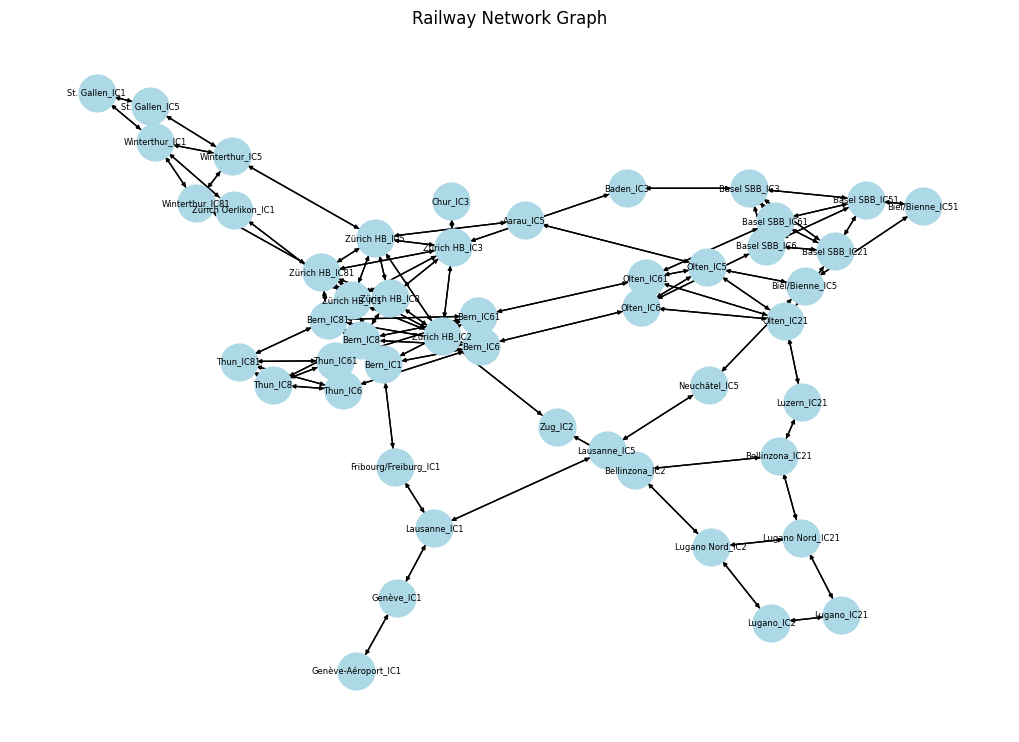

In [13]:
G = nx.DiGraph()

for _, row in df_network.iterrows():
    G.add_edge(row['source_id'], row['dest_id'], weight=row['travel_time'])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42) 
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', arrowsize=6, font_size=6)
plt.title('Railway Network Graph')
plt.show()

## All or nothing assignment 

Since we have modeled our network with all these seperate nodes and edges to represent transfers, we can easily use the label correction algorithm used for standard traffic assignment 

However, to be able to give the algorithm just a city name and not a city_line combo, we had to do a quick manipulation 

In [14]:
def shortest_path_tree(df_node, df_link, t, org): 

    """
    Generate shortest path tree from a given origin node
    using label correction
    
    :param df_node, df_link: network data frames
    :param t: link cost
    :param org: origin node
    
    :return u: node label
    :return p: previous link on shortest path for each node
    """
    
    # define inputs
    n_node = len(df_node)

    r = int(org)

    outflow_link_frst = df_node.frst_out.values
    outflow_link_lst = df_node.lst_out.values

    start_node = df_link.start_node.values
    end_node = df_link.end_node.values


    # initialize
    u = np.inf * np.ones(n_node)
    u[r] = 0
    p = -1 * np.ones(n_node, dtype=int)
    Q = queue.Queue()
    Q.put(r) 

    while Q.qsize() > 0:

        node_i = Q.get()

        link_frst = outflow_link_frst[node_i]
        link_lst = outflow_link_lst[node_i]
        
        for link in range(link_frst, link_lst+1):
            node_j = end_node[link]
            if u[node_j] > u[node_i] + t[link]:
                u[node_j] = u[node_i] + t[link]
                p[node_j] = link  # instead of start node, assigning link here
                if node_j not in Q.queue:
                    Q.put(node_j)

    return u, p
    

In [15]:
def label_correction(t, r, n_node, outflow_link_frst, outflow_link_lst, end_node):
    
    """
    Generate shortest path tree from a given origin node using label correction

    :param t: link cost 
    :param r: origin node index
    :param n_node: number of nodes

    :param outflow_link_frst (outflow_link_lst): list of first (last) outflow link indices for each node
    :param end_node: list of end node indices for each link

    :return u: node label
    :return p: previous link on shortest path for each node
    """

    # initialize
    u = np.inf * np.ones(n_node)
    u[r] = 0
    p = -1 * np.ones(n_node, dtype=int)
    Q = queue.Queue()
    Q.put(r) 

    while Q.qsize() > 0 :

        node_i = Q.get() 

        link_frst = outflow_link_frst[node_i]
        link_lst = outflow_link_lst[node_i]
        
        for link in range(link_frst, link_lst + 1):

            node_j = end_node[link]

            if u[node_j] > u[node_i] + t[link] :

                u[node_j] = u[node_i] + t[link]
                p[node_j] = link
                Q.put(node_j)


    return u, p

In [16]:
def prepare_for_dijkstra(network_df):
    
    network_df = network_df.sort_values(['source_id', 'dest_id']).reset_index(drop=True)
    network_df['link_index'] = network_df.index

    grouped = network_df.groupby('source_id')['link_index'].agg(['min', 'max']).reset_index()

    node_df = pd.DataFrame({'node_id': grouped['source_id'],'frst_out': grouped['min'],'lst_out': grouped['max']})
    
    node_to_idx = {node: idx for idx, node in enumerate(node_df['node_id'])}
    end_node_indices = np.array([node_to_idx.get(node, -1) for node in network_df['dest_id']])
    

    # Create station to node mapping for flexible querying ---> so we can use just city names
    station_to_nodes = {}
    for node_id in node_df['node_id']:
        if '_' in node_id:
            station = node_id.split('_')[0]
            if station not in station_to_nodes:
                station_to_nodes[station] = []
            station_to_nodes[station].append(node_id)
    
    return node_df, node_to_idx, end_node_indices, network_df, station_to_nodes

In [17]:
def get_origin_nodes(origin_input, node_to_idx, station_to_nodes):

    if origin_input in node_to_idx:
        return [node_to_idx[origin_input]]
    
    if origin_input in station_to_nodes:
        return [node_to_idx[node_id] for node_id in station_to_nodes[origin_input]]
    
    raise ValueError(f"Origin '{origin_input}' not found in network")

In [18]:
node_df, node_to_idx, end_node_indices, network_df_sorted, station_to_nodes = prepare_for_dijkstra(df_network)

n_node = len(node_df)
outflow_link_frst = node_df['frst_out'].values
outflow_link_lst = node_df['lst_out'].values
link_costs = network_df_sorted['travel_time'].values

In [ ]:
def all_or_nothing_assignment(df_od, node_df, network_df_sorted, node_to_idx, station_to_nodes, t):
    
    # Initialize link flows
    n_link = len(network_df_sorted)
    x = np.zeros(n_link)
    
    # Debug counters
    total_demand_processed = 0
    missing_origins = 0
    missing_destinations = 0
    successful_assignments = 0
    
    # Get network parameters
    n_node = len(node_df)
    outflow_link_frst = node_df['frst_out'].values
    outflow_link_lst = node_df['lst_out'].values
    end_node_indices = np.array([node_to_idx.get(node, -1) for node in network_df_sorted['dest_id']])
    
    unique_origins = np.unique(df_od['org'].values)
    print(f"Processing {len(unique_origins)} unique origins")
    print(f"Sample origins: {list(unique_origins[:5])}")
    
    for i, origin_station in enumerate(unique_origins):
        if i % 5 == 0: 
            print(f"Processing origin {i+1}/{len(unique_origins)}: {origin_station}")
        
        if origin_station in station_to_nodes:
            origin_indices = [node_to_idx[node_id] for node_id in station_to_nodes[origin_station]]
        elif origin_station in node_to_idx:
            origin_indices = [node_to_idx[origin_station]]
        else:
            print(f"ERROR: Origin {origin_station} not found in network")
            missing_origins += 1
            continue
        
        best_u = np.inf * np.ones(n_node)
        best_p = -1 * np.ones(n_node, dtype=int)
        
        for origin_idx in origin_indices:
            u, p = label_correction(t, origin_idx, n_node, outflow_link_frst, outflow_link_lst, end_node_indices)
            
            for j in range(n_node):
                if u[j] < best_u[j]:
                    best_u[j] = u[j]
                    best_p[j] = p[j]
        
        origin_ods = df_od[df_od['org'] == origin_station]
        
        for _, od_row in origin_ods.iterrows():
            dest_station = od_row['dest']
            demand = od_row['q']
            total_demand_processed += demand
            
            if dest_station in station_to_nodes:
                dest_node_id = station_to_nodes[dest_station][0]
                dest_idx = node_to_idx[dest_node_id]
            elif dest_station in node_to_idx:
                dest_idx = node_to_idx[dest_station]
            else:
                print(f"ERROR: Destination {dest_station} not found in network")
                missing_destinations += 1
                continue
            
            if best_u[dest_idx] == np.inf:
                print(f"ERROR: {dest_station} unreachable from {origin_station}")
                continue
            
            current_node = dest_idx
            path_length = 0
            max_path_length = n_node
            links_in_path = []
            
            while best_p[current_node] != -1 and path_length < max_path_length:
                link_idx = best_p[current_node]
                links_in_path.append(link_idx)
                x[link_idx] += demand
                
                # Move to previous node
                source_node_id = network_df_sorted.iloc[link_idx]['source_id']
                current_node = node_to_idx[source_node_id]
                path_length += 1
            
            if path_length >= max_path_length:
                print(f"ERROR: Infinite loop for {origin_station} -> {dest_station}")
            else:
                successful_assignments += 1
                
            if successful_assignments <= 3:
                print(f"  OD: {origin_station} -> {dest_station}, demand: {demand}, path length: {path_length}")
    
    print(f"\n=== SUMMARY ===")
    print(f"Total demand in OD matrix: {df_od['q'].sum()}")
    print(f"Total demand processed: {total_demand_processed}")
    print(f"Missing origins: {missing_origins}")
    print(f"Missing destinations: {missing_destinations}")
    print(f"Successful assignments: {successful_assignments}")
    print(f"Total assigned flow: {x.sum()}")
    print(f"Links with zero flow: {np.sum(x == 0)}/{len(x)}")
    print(f"Links with positive flow: {np.sum(x > 0)}/{len(x)}")
    
    return x

In [20]:
# total_demand = df_od['q'].sum()
# total_assigned = x.sum()
# print(f"Total demand: {total_demand}")
# print(f"Total assigned: {total_assigned}")

## Frank- Wolf

In [21]:
def line_search(network_df_sorted, x, y, max_gap):
    """
    Determine step size by bisection line search

    :param df_link: link data frame
    :param x: current link flows
    :param y: target link flows
    :param max_gap: gap threshold
    :return step: optimal step size
    """

    # initialize 
    lb = 0
    ub = 1
    step = 0.5
    z = x + step * (y - x)
    t = link_cost_function(network_df_sorted, z)
    diff = np.dot(t, y - x)

    # main loop
    while ub - lb > max_gap or diff > 0:
        # update bounds based on boundary value difference
        if diff < 0:
            lb = step
        else:
            ub = step

        step = 0.5 * (lb + ub)
        z = x + step * (y - x)
        t = link_cost_function(network_df_sorted, z)
        diff = np.dot(t, y - x)


    return step

In [22]:
def static_assignment_fw(df_od, df_node, network_df_sorted, max_iter, max_gap, max_gap_ls):
    
    """
    Solve static traffic assignment 
    using Frank-Wolfe algorithm

    :param df_od, df_node, df_link: network data frames
    :param max_iter: max number of iterations of main loop
    :param max_gap: gap threshold of main loop
    :param max_gap_ls: gap threshold of line search
    :return x_star: equilibrium link flow
    :return gap: gap over iterations
    :return obj: objective value over iterations
    """

    # initialize link flow 
    n_link = len(network_df_sorted)
    x = np.zeros(n_link)
    t = link_cost_function(network_df_sorted, x)
    x = all_or_nothing_assignment(df_od, df_node, network_df_sorted, node_to_idx, station_to_nodes, t)

    # main loop 
    gap = np.inf * np.ones(max_iter)
    obj = np.inf * np.ones(max_iter)
    i = 0

    for i in range(max_iter):
        # update link travel time
        t = link_cost_function(network_df_sorted, x)

        # solve target flow
        y = all_or_nothing_assignment(df_od, df_node, network_df_sorted, node_to_idx, station_to_nodes, t)

        # derive step size by line search
        step = line_search(network_df_sorted, x, y, max_gap_ls)

        # compute relative gap
        gap[i] = np.dot(t, x-y)/np.dot(t, x)

        # update link flow
        x += step * (y - x)

        # compute objective value
        obj[i] = objective(x, t, network_df_sorted)

        # check convergence 
        if gap[i] < max_gap:
            break

    # process outputs
    x_star = x
    gap = gap[:i+1]
    obj = obj[:i+1]

    return x_star, gap, obj

## Linear Link Cost - UE

In [23]:
def crowding_cost_function(network_df_sorted, x):
    cap = network_df_sorted['capacity'].values
    travel_time = network_df_sorted['travel_time'].values
    
    d = x / cap
    
    crowding_multiplier = 1 + 0.15* d**4
    
    t = travel_time * crowding_multiplier

    return t

In [24]:
def objective(x, t, network_df_sorted):

    cap = network_df_sorted['capacity'].values
    travel_time = network_df_sorted['travel_time'].values
    d = x/cap
    
    t = travel_time*x*(1 + 0.03*d**4)
    obj = sum(t)
    
    return obj

In [25]:
def link_cost_function(network_df_sorted, x):

    t = crowding_cost_function(network_df_sorted, x)
    
    return t

In [26]:
def total_system_cost(network_df_sorted, x):

    link_cost = x*crowding_cost_function(network_df_sorted,x)
    TC =  sum(link_cost)
    return TC

In [27]:
max_iter = 100
max_gap = 1e-4
max_gap_ls = 1e-2

In [28]:
x, gap, obj = static_assignment_fw(df_od, node_df, network_df_sorted, max_iter, max_gap, max_gap_ls)

Processing 21 unique origins
Sample origins: ['Aarau', 'Baden', 'Basel SBB', 'Bellinzona', 'Bern']
Processing origin 1/21: Aarau
  OD: Aarau -> Bern, demand: 7897.0, path length: 4
  OD: Aarau -> Basel SBB, demand: 5338.0, path length: 3
  OD: Aarau -> Lausanne, demand: 6356.0, path length: 5
Processing origin 6/21: Biel/Bienne
Processing origin 11/21: Lausanne
Processing origin 16/21: St. Gallen
Processing origin 21/21: Zürich Oerlikon

=== SUMMARY ===
Total demand in OD matrix: 2338592.0
Total demand processed: 2338592.0
Missing origins: 0
Missing destinations: 0
Successful assignments: 420
Total assigned flow: 8900963.0
Links with zero flow: 85/190
Links with positive flow: 105/190
Processing 21 unique origins
Sample origins: ['Aarau', 'Baden', 'Basel SBB', 'Bellinzona', 'Bern']
Processing origin 1/21: Aarau
  OD: Aarau -> Bern, demand: 7897.0, path length: 4
  OD: Aarau -> Basel SBB, demand: 5338.0, path length: 4
  OD: Aarau -> Lausanne, demand: 6356.0, path length: 9
Processing o

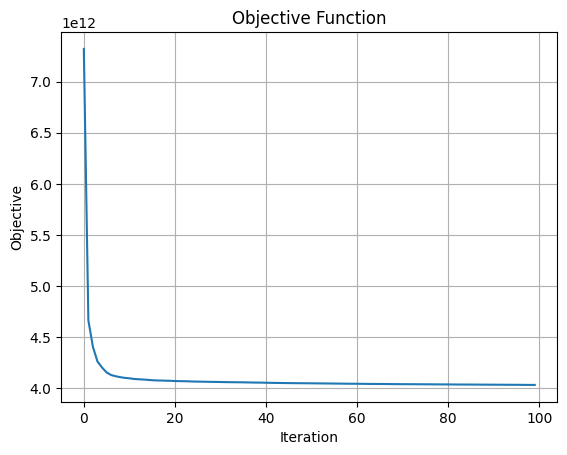

In [29]:
plt.figure()
plt.plot(obj)
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.title('Objective Function')
plt.grid()

In [30]:
zero_indices = np.where(x == 0.0)[0]  # [0] perché np.where restituisce una tupla
print("Indici degli zeri:", zero_indices)
zero_flow_link = network_df_sorted.loc[zero_indices]
zero_flow_link

Indici degli zeri: [  6   7  22  27  48  56  62  82  85  88 115 120 121 122 125 126 129 130
 133 134]


,start_node,end_node,distance [m],IC_lines,is_transfer,transfer_time,source_line,dest_line,source_id,dest_id,headway,speed,travel_time,capacity,link_index
6,Basel SBB,Basel SBB,0.0,TRANSFER_IC21_to_IC6,True,5.0,IC21,IC6,Basel SBB_IC21,Basel SBB_IC6,30,0,20.0,inf,6
7,Basel SBB,Basel SBB,0.0,TRANSFER_IC21_to_IC61,True,5.0,IC21,IC61,Basel SBB_IC21,Basel SBB_IC61,30,0,20.0,inf,7
22,Basel SBB,Basel SBB,0.0,TRANSFER_IC6_to_IC61,True,5.0,IC6,IC61,Basel SBB_IC6,Basel SBB_IC61,30,0,20.0,inf,22
27,Basel SBB,Basel SBB,0.0,TRANSFER_IC61_to_IC6,True,5.0,IC61,IC6,Basel SBB_IC61,Basel SBB_IC6,30,0,20.0,inf,27
48,Bern,Bern,0.0,TRANSFER_IC61_to_IC6,True,5.0,IC61,IC6,Bern_IC61,Bern_IC6,30,0,20.0,inf,48
56,Bern,Bern,0.0,TRANSFER_IC8_to_IC81,True,5.0,IC8,IC81,Bern_IC8,Bern_IC81,30,0,20.0,inf,56
62,Bern,Bern,0.0,TRANSFER_IC81_to_IC8,True,5.0,IC81,IC8,Bern_IC81,Bern_IC8,60,0,35.0,inf,62
82,Lugano Nord,Lugano Nord,0.0,TRANSFER_IC2_to_IC21,True,5.0,IC2,IC21,Lugano Nord_IC2,Lugano Nord_IC21,60,0,35.0,inf,82
85,Lugano Nord,Lugano Nord,0.0,TRANSFER_IC21_to_IC2,True,5.0,IC21,IC2,Lugano Nord_IC21,Lugano Nord_IC2,60,0,35.0,inf,85
88,Lugano,Lugano,0.0,TRANSFER_IC2_to_IC21,True,5.0,IC2,IC21,Lugano_IC2,Lugano_IC21,60,0,35.0,inf,88


In [31]:
final_link_cost = link_cost_function(network_df_sorted, x)

In [32]:
network_df_sorted['link_flow'] = x
network_df_sorted['link_cost'] = final_link_cost

In [33]:
transfer_link = network_df_sorted[network_df_sorted['is_transfer']== True]
transfer_link = transfer_link[~transfer_link['start_node'].isin(to_remove)]

line_link = network_df_sorted[network_df_sorted['is_transfer']== False]

In [34]:
line_grouped = line_link.groupby(by='IC_lines').sum()
transfer_grouped = transfer_link.groupby(by='start_node').sum()

In [35]:
line_flow_sorted = line_link.sort_values(by='link_flow', ascending=False)
line_flow_sorted.head()

,start_node,end_node,distance [m],IC_lines,is_transfer,transfer_time,source_line,dest_line,source_id,dest_id,headway,speed,travel_time,capacity,link_index,link_flow,link_cost
66,Biel/Bienne,Neuchâtel,29200.120,IC5,False,NaN,IC5,IC5,Biel/Bienne_IC5,Neuchâtel_IC5,30,80,36.900090,15000.0,66,365561.762522,1.952562e+06
94,Neuchâtel,Lausanne,75087.957,IC5,False,NaN,IC5,IC5,Neuchâtel_IC5,Lausanne_IC5,30,80,71.315968,15000.0,94,332464.101442,2.581690e+06
77,Lausanne,Genève,60226.630,IC1,False,NaN,IC1,IC1,Lausanne_IC1,Genève_IC1,60,80,75.169973,7500.0,77,327390.000000,4.094049e+07
101,Olten,Biel/Bienne,60070.608,IC5,False,NaN,IC5,IC5,Olten_IC5,Biel/Bienne_IC5,30,80,60.052956,15000.0,101,280962.446540,1.108861e+06
93,Neuchâtel,Biel/Bienne,29200.120,IC5,False,NaN,IC5,IC5,Neuchâtel_IC5,Biel/Bienne_IC5,30,80,36.900090,15000.0,93,247281.001507,4.088423e+05


In [36]:
total_lnk = network_df_sorted.groupby(['start_node', 'end_node'])['link_flow'].sum().reset_index()
link_without_t = total_lnk[total_lnk['start_node']!=total_lnk['end_node']].reset_index()
pd.set_option('display.max_rows', None)
display(link_without_t)

,index,start_node,end_node,link_flow
0,0,Aarau,Olten,217290.957093
1,1,Aarau,Zürich HB,167141.335736
2,2,Baden,Basel SBB,183456.706105
3,3,Baden,Zürich HB,147490.124951
4,4,Basel SBB,Baden,144271.563431
5,6,Basel SBB,Biel/Bienne,128806.219466
6,7,Basel SBB,Olten,195725.919025
7,9,Bellinzona,Lugano Nord,90208.000000
8,10,Bellinzona,Luzern,37005.456929
9,11,Bellinzona,Zug,64567.994754


#### Plot

10 10


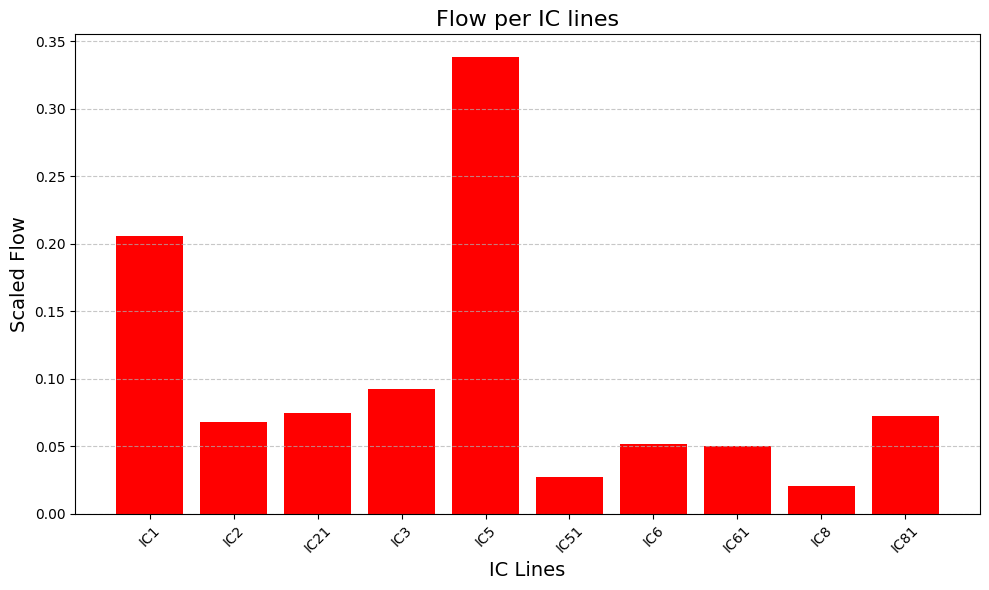

In [37]:
# Extract data
lines = line_grouped.index  # IC line names (e.g., 'IC1', 'IC2')
total_flow = line_grouped['link_flow'].sum()
flows = line_grouped['link_flow'].values/total_flow  # Flow values
print(len(flows), len(lines))

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(lines, flows, color='red')
plt.xlabel('IC Lines', fontsize = 14)
plt.ylabel('Scaled Flow', fontsize = 14)
plt.title('Flow per IC lines',fontsize = 16)
plt.xticks(rotation=45)  # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('flow_ic.png')
plt.show()

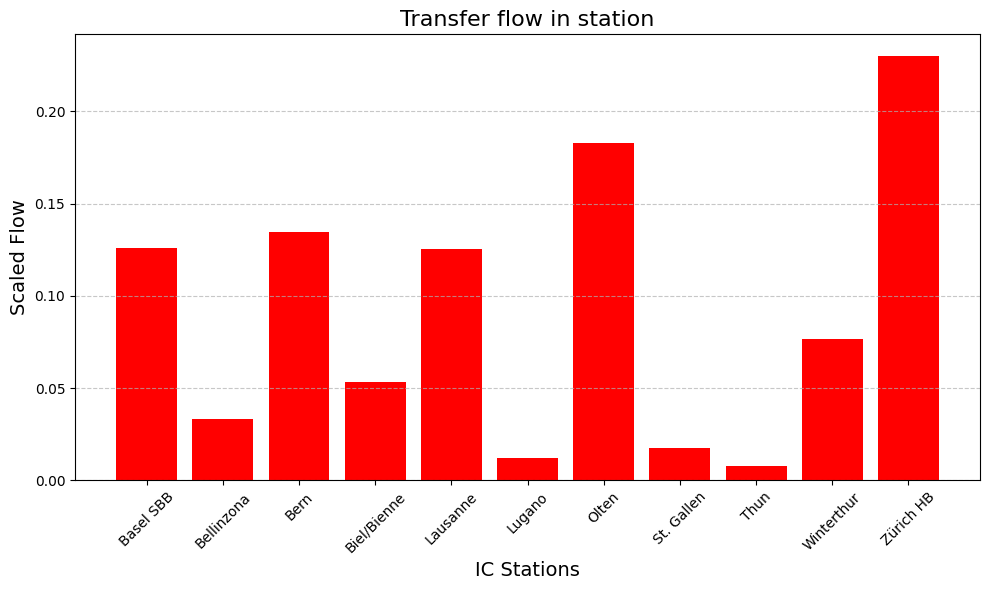

In [ ]:
# Extract data
lines_tr = transfer_grouped.index
total_flow_tr = transfer_grouped['link_flow'].sum()
flows_tr = transfer_grouped['link_flow'].values/total_flow_tr 


# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(lines_tr, flows_tr, color='red')
plt.xlabel('IC Stations', fontsize = 14)
plt.ylabel('Scaled Flow', fontsize = 14)
plt.title('Transfer flow in station',fontsize = 16)
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('transfer.png')
plt.show()

In [39]:
TC_ue = total_system_cost(network_df_sorted, x)

## Swisssmetro

In [40]:
df_link_sm = df_links.copy()


In [ ]:
# # Add new row
df_link_sm.loc[len(df_link_sm)] = ['Lausanne', 'Zürich HB', 175000.0, 'SM']  

In [42]:
df_link_sm

,start_node,end_node,distance [m],IC_lines
0,Zürich HB,Chur,116075.402,IC3
1,Zürich HB,Winterthur,26787.367,"IC5, IC81"
2,Zürich HB,Baden,22587.175,IC3
3,Zürich HB,Bern,120492.589,"IC1, IC8, IC81"
4,Zürich HB,Zürich Oerlikon,5368.417,IC1
5,Zürich HB,Zug,28929.698,IC2
6,Zürich HB,Aarau,41492.905,IC5
7,Winterthur,St. Gallen,57139.042,"IC1, IC5"
8,Winterthur,Zürich Oerlikon,21418.950,IC1
9,Basel SBB,Baden,83614.363,IC3


In [43]:
df_expanded = process_multi_line_connections(df_link_sm)
df_bidirectional = create_bidirectional_network(df_expanded)
full_network = add_transfer_edges(df_bidirectional, transfer_time=T)
full_network_with_names = create_node_line_pairs(full_network)

full_network_with_names['headway'] = full_network_with_names.apply(add_headway, axis=1)

full_network_with_names['speed'] = full_network_with_names.apply(add_speed, axis=1)



df_network = calculate_travel_times(full_network_with_names)    

df_network['capacity'] = df_network.apply(add_capacity, axis=1)

In [44]:
node_df, node_to_idx, end_node_indices, network_df_sorted_sm, station_to_nodes = prepare_for_dijkstra(df_network)

n_node = len(node_df)
outflow_link_frst = node_df['frst_out'].values
outflow_link_lst = node_df['lst_out'].values
link_costs = network_df_sorted_sm['travel_time'].values


In [45]:
x, gap, obj = static_assignment_fw(df_od, node_df, network_df_sorted_sm, max_iter, max_gap, max_gap_ls)

Processing 21 unique origins
Sample origins: ['Aarau', 'Baden', 'Basel SBB', 'Bellinzona', 'Bern']
Processing origin 1/21: Aarau
  OD: Aarau -> Bern, demand: 7897.0, path length: 4
  OD: Aarau -> Basel SBB, demand: 5338.0, path length: 3
  OD: Aarau -> Lausanne, demand: 6356.0, path length: 4
Processing origin 6/21: Biel/Bienne
Processing origin 11/21: Lausanne
Processing origin 16/21: St. Gallen
Processing origin 21/21: Zürich Oerlikon

=== SUMMARY ===
Total demand in OD matrix: 2338592.0
Total demand processed: 2338592.0
Missing origins: 0
Missing destinations: 0
Successful assignments: 420
Total assigned flow: 8270895.0
Links with zero flow: 90/208
Links with positive flow: 118/208
Processing 21 unique origins
Sample origins: ['Aarau', 'Baden', 'Basel SBB', 'Bellinzona', 'Bern']
Processing origin 1/21: Aarau
  OD: Aarau -> Bern, demand: 7897.0, path length: 4
  OD: Aarau -> Basel SBB, demand: 5338.0, path length: 4
  OD: Aarau -> Lausanne, demand: 6356.0, path length: 9
Processing o

In [46]:
TC_sm = total_system_cost(network_df_sorted_sm, x)

In [ ]:
zero_indices = np.where(x == 0.0)[0]  
print("Indici degli zeri:", zero_indices)
zero_flow_link = network_df_sorted_sm.loc[zero_indices]
#zero_flow_link

Indici degli zeri: [  6   7  22  27  42  43  48  50  56  62  81  87  90  93 120 125 126 127
 130 131 134 135 138 139 190 204]


In [48]:
final_link_cost_sm = link_cost_function(network_df_sorted_sm, x)

In [49]:
network_df_sorted_sm['link_flow'] = x
network_df_sorted_sm['link_cost'] = final_link_cost_sm

In [50]:
transfer_link_sm = network_df_sorted_sm[network_df_sorted_sm['is_transfer']== True]
transfer_link_sm = transfer_link_sm[~transfer_link_sm['start_node'].isin(to_remove)]

line_link_sm = network_df_sorted_sm[network_df_sorted_sm['is_transfer']== False]

In [51]:
line_grouped_sm = line_link_sm.groupby(by='IC_lines').sum()
transfer_grouped_sm = transfer_link_sm.groupby(by='start_node').sum()

In [52]:
line_flow_sorted_sm = line_link_sm.sort_values(by='link_flow', ascending=False)
line_flow_sorted_sm.head()

,start_node,end_node,distance [m],IC_lines,is_transfer,transfer_time,source_line,dest_line,source_id,dest_id,headway,speed,travel_time,capacity,link_index,link_flow,link_cost
77,Lausanne,Genève,60226.630,IC1,False,NaN,IC1,IC1,Lausanne_IC1,Genève_IC1,60,80,75.169973,7500.0,77,327390.000000,4.094049e+07
66,Biel/Bienne,Neuchâtel,29200.120,IC5,False,NaN,IC5,IC5,Biel/Bienne_IC5,Neuchâtel_IC5,30,80,36.900090,15000.0,66,262477.337611,5.189814e+05
99,Neuchâtel,Lausanne,75087.957,IC5,False,NaN,IC5,IC5,Neuchâtel_IC5,Lausanne_IC5,30,80,71.315968,15000.0,99,232035.023765,6.126010e+05
75,Genève,Lausanne,60226.630,IC1,False,NaN,IC1,IC1,Genève_IC1,Lausanne_IC1,60,80,75.169973,7500.0,75,226478.000000,9.375580e+06
106,Olten,Biel/Bienne,60070.608,IC5,False,NaN,IC5,IC5,Olten_IC5,Biel/Bienne_IC5,30,80,60.052956,15000.0,106,210790.282410,3.513478e+05


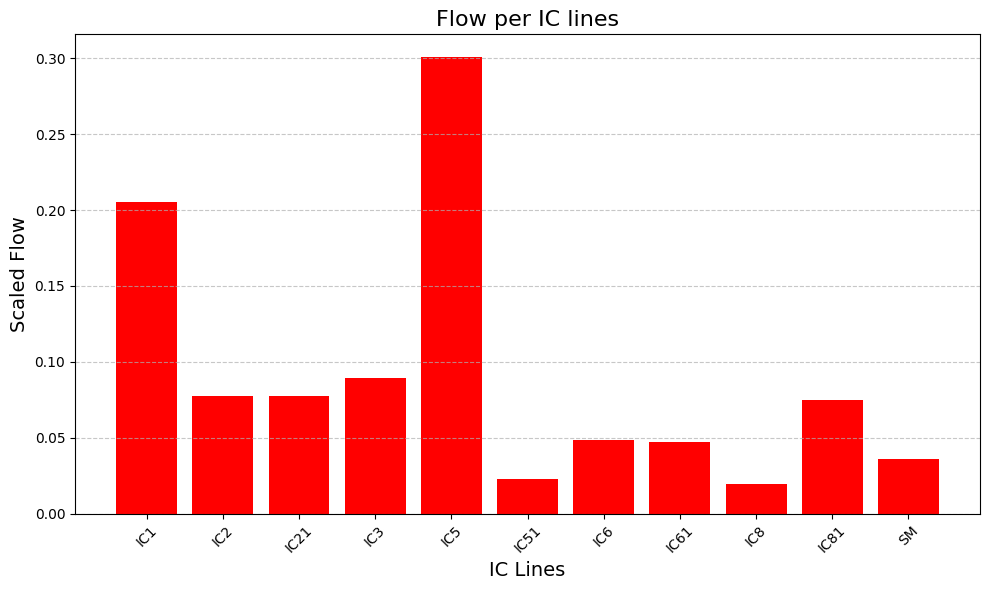

In [ ]:
lines_sm = line_grouped_sm.index 
total_flow_sm = line_grouped_sm['link_flow'].sum()
flows_sm = line_grouped_sm['link_flow'].values/total_flow_sm  

plt.figure(figsize=(10, 6))
plt.bar(lines_sm, flows_sm, color='red')
plt.xlabel('IC Lines', fontsize = 14)
plt.ylabel('Scaled Flow', fontsize = 14)
plt.title('Flow per IC lines', fontsize = 16)
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('sm_flow.png')
plt.show()

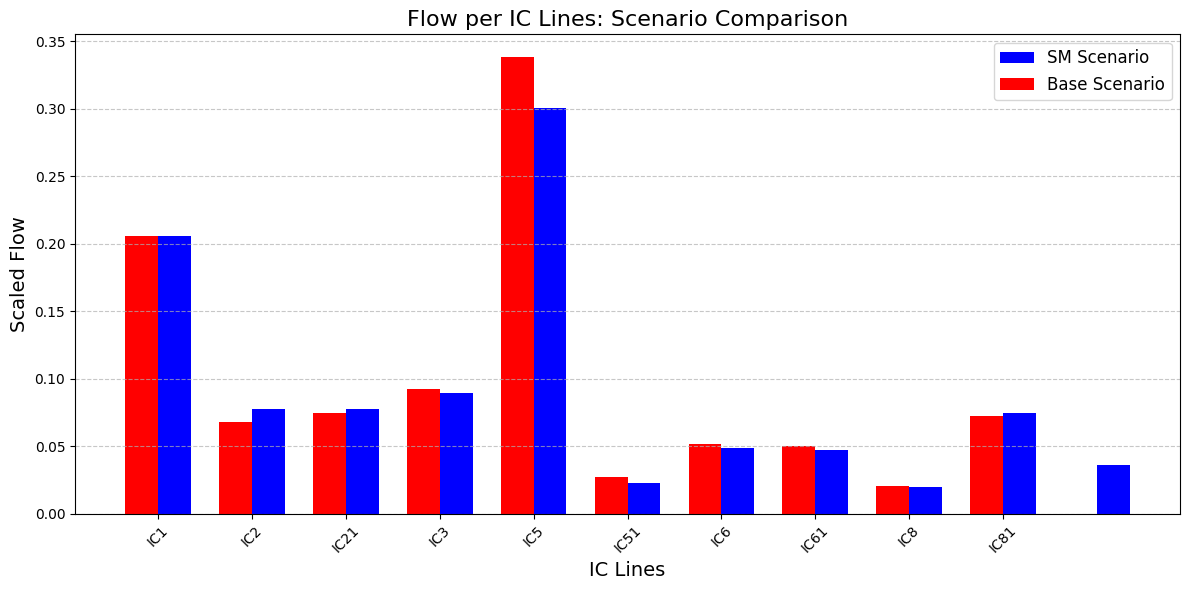

In [ ]:
bar_width = 0.35
x = np.arange(len(lines))  
x_sm = np.arange(len(lines_sm))  

plt.figure(figsize=(12, 6))

plt.bar(x_sm+ bar_width/2, flows_sm, bar_width, color='blue', label='SM Scenario')

plt.bar(x - bar_width/2, flows, bar_width, color='red', label='Base Scenario')

plt.xlabel('IC Lines', fontsize=14)
plt.ylabel('Scaled Flow', fontsize=14)
plt.title('Flow per IC Lines: Scenario Comparison', fontsize=16)
plt.xticks(x, lines, rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('scenario_comparison.png', dpi=300)
plt.show()

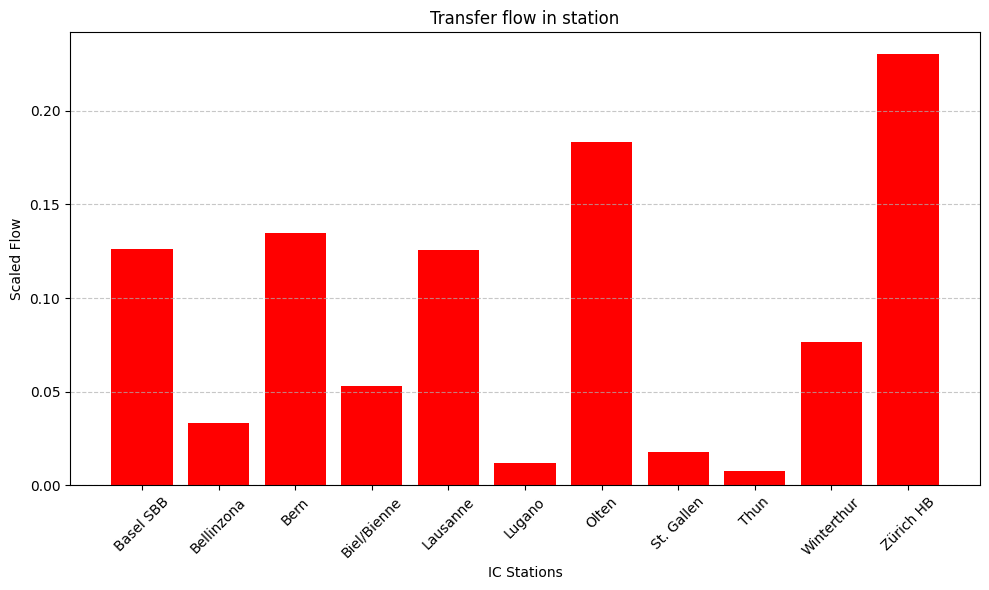

In [ ]:
lines = transfer_grouped.index
total_flow = transfer_grouped['link_flow'].sum()
flows = transfer_grouped['link_flow'].values/total_flow  

plt.figure(figsize=(10, 6))
plt.bar(lines, flows, color='red')
plt.xlabel('IC Stations')
plt.ylabel('Scaled Flow')
plt.title('Transfer flow in station')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('sm_transfer.png')
plt.show()

In [56]:
TC_ue

np.float64(20164158185540.18)

In [57]:
TC_sm

np.float64(17379740916864.49)

In [58]:
change = TC_sm/TC_ue
change

np.float64(0.8619125458620728)